In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from halotools.mock_observables import tpcf_multipole

from gsm.measurements import compute_real_tpcf, compute_tpcf_s_mu
from gsm.wrappers import skewt

In [2]:
num_threads = 6

In [3]:
import os
os.environ["JULIA_PROJECT"] = "/cosma/home/dp004/dc-cues1/PairwiseVelocities"
os.environ["JULIA_NUM_THREADS"] = str(num_threads)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import PairwiseVelocities

## Read data

In [4]:
boxsize = 2000.
redshift = 0.

In [5]:
DATA_DIR = Path('data/example_data/')
pos_left = np.loadtxt(DATA_DIR / 'pos_left.dat') # In Mpc/h
pos_right = np.loadtxt(DATA_DIR / 'pos_right.dat') # In Mpc/h
vel_left = np.loadtxt(DATA_DIR / 'vel_left.dat') # In km/s
vel_right = np.loadtxt(DATA_DIR / 'vel_right.dat') # In km/s


In [6]:
pos_left.shape

(800000, 3)

In [7]:
pos_right.shape

(80000, 3)

## Compute real and redshift space tpcf

In [8]:
%%time

r_bins = np.linspace(1.,60,100)
r_c = 0.5*(r_bins[1:] + r_bins[:-1])
real_tpcf = compute_real_tpcf(
    r_bins, pos_right,
    boxsize=boxsize,
    pos_cross=pos_left,
    num_threads = num_threads
)


CPU times: user 572 ms, sys: 256 ms, total: 828 ms
Wall time: 1.21 s


In [9]:
# Define a cosmology to move objects to redshift space
class Cosmology:
    def __init__(self, Omega_m: float, Omega_de: float, w:float):
        self.Omega_m = Omega_m
        self.Omega_de = Omega_de
        self.w = w
        
    def efunc(self, redshift: float) -> float:
        inv_scale = 1.0 + redshift
        return np.sqrt(
            (inv_scale ** 3) * self.Omega_m
            + inv_scale ** (3 * (1 + self.w)) * self.Omega_de
        )

cosmology = Cosmology(Omega_m=0.3156, Omega_de=0.6844, w=-1.)

In [10]:
%%time

n_mu_bins = 60
mu_bins = (1 + np.geomspace(-0.001, -1, n_mu_bins))[::-1]
mu_c = 0.5*(mu_bins[1:] + mu_bins[:-1])

s_mu_tpcf = compute_tpcf_s_mu(
    s=r_bins, 
    mu=mu_bins, 
    pos=pos_right, 
    vel=vel_right,
    los_direction=2, #x,y,z
    redshift=redshift,
    cosmology=cosmology,
    boxsize=boxsize,
    num_threads = num_threads,
    pos_cross=pos_left,
    vel_cross=vel_left,

)

CPU times: user 642 ms, sys: 252 ms, total: 893 ms
Wall time: 1.32 s


In [11]:
monopole = tpcf_multipole(
    s_mu_tpcf, 
    mu_bins, 
    order=0
)
quadrupole = tpcf_multipole(
    s_mu_tpcf, 
    mu_bins, 
    order=2
)
hexadecapole = tpcf_multipole(
    s_mu_tpcf, 
    mu_bins, order=4)

Text(0.5, 0, 'r [Mpc/h]')

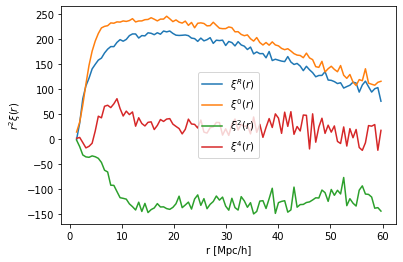

In [12]:
plt.plot(r_c, r_c**2*real_tpcf,
        label=r'$\xi^R(r)$')
plt.plot(r_c, r_c**2*monopole,
        label=r'$\xi^0(r)$')
plt.plot(r_c, r_c**2*quadrupole,
        label=r'$\xi^2(r)$')
plt.plot(r_c, r_c**2*hexadecapole,
        label=r'$\xi^4(r)$')
plt.legend()
plt.ylabel(r'$r^2\xi(r)$')
plt.xlabel('r [Mpc/h]')

## Compute velocity moments

In [13]:
%%time
#TODO: Right now it adds compilation time :( can we somehow precompile julia code?
moments = PairwiseVelocities.compute_pairwise_velocity_moments(pos_right.T, #julia likes transpose
                                                                vel_right.T,
                                                                pos_left.T,
                                                                vel_left.T,
                                                                r_bins, 
                                                               boxsize)


Using n = 6 threads
CPU times: user 17.3 s, sys: 622 ms, total: 17.9 s
Wall time: 11.5 s


In [14]:
moments = [moments[i] for i in [1,2,5,3,6,4,7,8]]

In [15]:
len(moments) # v_r, std_r, std_t, skewness_r, skewness_rt, kurtosis_r, kurtosis_t, kurtosis_rt

8

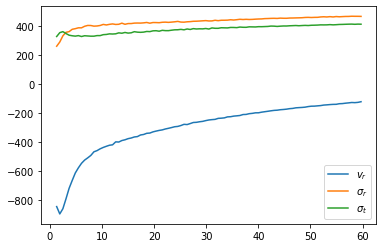

In [16]:
plt.plot(r_c, moments[0],label=r'$v_r$') # In km/s
plt.plot(r_c, moments[1],label=r'$\sigma_r$')
plt.plot(r_c, moments[2],label=r'$\sigma_t$')
plt.legend()

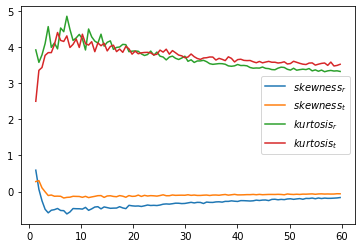

In [17]:
plt.plot(r_c, moments[3],label=r'$skewness_r$') # Unitless
plt.plot(r_c, moments[4],label=r'$skewness_t$')
plt.plot(r_c, moments[5],label=r'$kurtosis_r$')
plt.plot(r_c, moments[6],label=r'$kurtosis_t$')
plt.legend()

## Apply ST

In [18]:
moments = np.array(moments).T
moments[:,:3] /= 100.*cosmology.efunc(redshift=0.) # First three moments have units of km/s, convert to Mpc/h

In [19]:
%%time

_, st_multipoles = skewt.compute_multipoles_skewt_from_scaled(
    r = r_c,# values at which moments are evaluated
    scaled_moments = moments,
    real_xi = UnivariateSpline(r_c, real_tpcf,s=0),
    rbins_c=r_c, # values at which multipoles are evaluated,
    r_max_int = 60.,
    use_spl=False, # Use some interpolation for the ST model 
    # (approx. and only adapted to certain number densities)
)

/cosma/home/dp004/dc-cues1/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


CPU times: user 10.9 s, sys: 404 ms, total: 11.3 s
Wall time: 11.1 s


Text(0.5, 0, 'r [Mpc/h]')

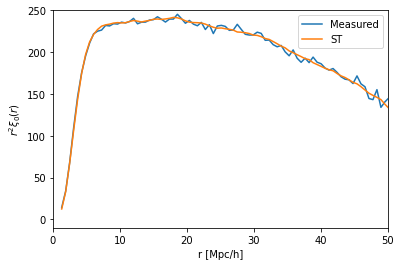

In [20]:
plt.plot(r_c, r_c**2*monopole,
        label='Measured')
plt.plot(r_c, r_c**2*st_multipoles[:,1],
        label='ST')
plt.xlim(0,50) # if you want larger scales, extend the integration
# limit on simps integrate + extend UnivariateSpline limits 
# for moments and correlation function, remember it is an integral!
plt.ylim(-10,250)
plt.legend()
plt.ylabel(r'$r^2\xi_0(r)$')
plt.xlabel('r [Mpc/h]')

Text(0.5, 0, 'r [Mpc/h]')

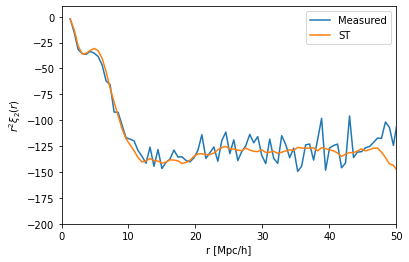

In [21]:
plt.plot(r_c, r_c**2*quadrupole,
        label='Measured')
plt.plot(r_c, r_c**2*st_multipoles[:,2],
        label='ST')
plt.xlim(0,50) # if you want larger scales, extend the integration
# limit on simps integrate + extend UnivariateSpline limits 
# for moments and correlation function, remember it is an integral!
plt.ylim(-200,10)
plt.legend()
plt.ylabel(r'$r^2\xi_2(r)$')
plt.xlabel('r [Mpc/h]')

Text(0.5, 0, 'r [Mpc/h]')

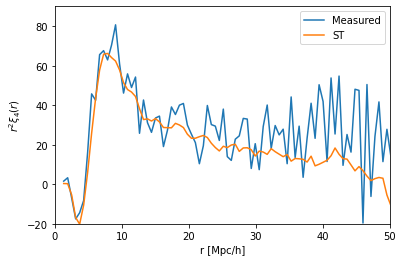

In [22]:
plt.plot(r_c, r_c**2*hexadecapole,
        label='Measured')
plt.plot(r_c, r_c**2*st_multipoles[:,3],
        label='ST')
plt.xlim(0,50) # if you want larger scales, extend the integration
# limit on simps integrate + extend UnivariateSpline limits 
# for moments and correlation function, remember it is an integral!
plt.ylim(-20,90)

plt.legend()
plt.ylabel(r'$r^2\xi_4(r)$')
plt.xlabel('r [Mpc/h]')